In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import numpy.random as npr
import scipy.optimize as opt
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import re

In [2]:
# Highest posterior density credible intervals
def hpd(trace, mass_frac):
    d = np.sort(np.copy(trace))
    n = len(trace)
    n_samples = np.floor(mass_frac * n).astype(int)
    int_width = d[n_samples:] - d[:n-n_samples]
    min_int = np.argmin(int_width)
    return np.array([d[min_int], d[min_int+n_samples]])

# Summary

Analyze posterior distributions of genetic drift and mutation rate parameters inferred by MOPE. See `run_mope.sh` for how to produce these data.

In [3]:
# Load in the data. Say the first 30% is burnin, although this is not necessary
# with the downsampled chains.
dat = pd.read_csv('results/downsampled_chains.txt.gz', sep='\t', compression='gzip')
frac_burn = 0.3
dat = dat.iloc[int(frac_burn*dat.shape[0]+0.5):,:]

In [4]:
dat.head(2)

,ll,bl_l,ch_l,eoo_post_l,eoo_pre_l,fblo_l,fbuc_l,loo_l,som_l,bl_m,ch_m,eoo_post_m,eoo_pre_m,fblo_m,fbuc_m,loo_m,som_m,log10ab,log10polyprob
30000,-13172.874365,0.0,0.0,0.132056,0.003121,0.011927,0.010170,0.000363,0.014905,NaN,NaN,2.686884e-06,6.775863e-06,7.155143e-08,1.480179e-08,0.000088,5.516483e-08,-2.238611,-2.779931
30001,-13170.869383,0.0,0.0,0.155020,0.002458,0.012064,0.006971,0.000282,0.018093,NaN,NaN,4.482617e-07,4.339268e-07,1.267212e-07,6.805832e-07,0.000238,3.042662e-08,-2.173346,-2.633224


In [5]:
get_bots = lambda age: 2.0/(age*dat['loo_l'] + dat['eoo_pre_l'] + dat['eoo_post_l'] + dat['som_l'])

In [6]:
length_columns = dat.filter(regex='_l$').columns
mut_columns = [lc.replace('_l', '_m') for lc in length_columns]

In [7]:
oplcolors = '''fblo #1f77b4   fixed
blo  #1f77b4   rate
fbuc #ff7f0e   fixed
buc  #ff7f0e   rate
som  #2ca02c   fixed
loo  #9467bd   rate
eoo_post  #d62728   fixed
eoo_pre  #ff8080   fixed'''
import cStringIO
oplcolorsio = cStringIO.StringIO(oplcolors)
colordat = pd.read_csv(oplcolorsio, sep='\s+', header=None, names=['tissue', 'color', 'type'])
colordat.columns = ['tissue', 'color', 'type']
color_dict = {row.tissue:row.color for row in colordat.itertuples(index=False)}
color_dict['bl'] = color_dict['blo']
color_dict['ch'] = color_dict['buc']
colordat.loc[colordat['tissue'] == 'eoo_pre','color'] = '#d62728'
colordat.loc[colordat['tissue'] == 'eoo_post','color'] = '#ff8080'

## plots

In [8]:
histbins = np.linspace(np.log10(5e-4), 0, 100)
mpl.rc('text', usetex = False)
better_labels = {
    'eoo': 'early oogenesis',
    'eoo_post': 'early oogenesis, post-divergence',
    'eoo_pre': 'early oogenesis, pre-divergence',
    'fblo': 'early somatic: blood',
    'fbuc': 'early somatic: cheek',
    'bl': 'adult somatic: blood',
    'ch': 'adult somatic: cheek',
    'loo': 'late oogensis: dictyate',
    'som': 'early somatic: pre-gastrulation'}
violin_data = []
violin_colors = []
violin_labels = []
violin_frac_zeros = []
for lc in length_columns:
    name = lc.replace('_l', '')
    if name in ['bl', 'ch']:
        continue
    color = color_dict[name]
    if name == 'loo':
        datp = dat[lc]*29.2
    else:
        datp = dat[lc]
    with np.errstate(divide='ignore'):
        tmp = np.log10(datp.values)
        violin_data.append(tmp[np.isfinite(tmp)])
    violin_colors.append(color)
    violin_labels.append(better_labels[name])
    violin_frac_zeros.append((datp == 0.0).sum() / datp.shape[0])

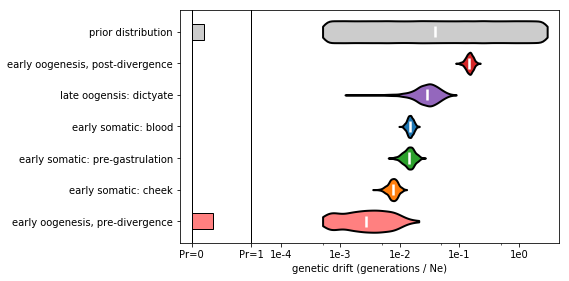

In [9]:
# Plot of posterior distributions of genetic drift parameters
mpl.rcParams['font.size'] = 10
uniform_sample = np.random.uniform(np.log10(5e-4), np.log10(3), size = 1000000)
frac_zero_uniform = 1.0/(np.log10(3)-np.log10(5e-5))
# this requires the previous cell be run in order to set up the violin plot data
lw = 2
f, ax = plt.subplots(figsize = (8,4))
n = 1000
violin_data_thinned = [np.random.choice(d, size=n, replace=False) for d in violin_data]
violin_order = np.argsort([np.median(vdt) for vdt in violin_data_thinned])
vd = [violin_data_thinned[el] for el in violin_order] + [uniform_sample]
vc = [violin_colors[el] for el in violin_order] + ['#cccccc']
vl = [violin_labels[el] for el in violin_order] + ['prior distribution']
parts = plt.violinplot(vd, showmedians=True, widths=0.7, vert=False, showextrema=False, bw_method='scott')
for pc, color in zip(parts['bodies'], vc):
    pc.set_facecolor(color)
    pc.set_alpha(1)
    pc.set_edgecolor('black')
    pc.set_linewidth(lw)
xticks = np.log10((1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1))
xtl = ('1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2', '1e-1', '5e-1', '1e0')
xticks_major = np.concatenate(([-5.5,-4.5], xticks[::2]))
xticks_minor = xticks[1:][::2]
xtl_major = np.concatenate((['Pr=0', 'Pr=1'], np.array(xtl)[::2]))

lw = 1.5
parts['cmedians'].set_color('white')
parts['cmedians'].set_linewidth(lw+1)

ax.axvline(-5.5, lw = 1, color = 'black')
ax.axvline(-4.5, lw = 1, color = 'black')
fzs = [violin_frac_zeros[el] for el in violin_order] + [frac_zero_uniform]

rect_width = 0.5
for i, (fz, color) in enumerate(zip(fzs, vc)):
    xy = (-5.5, i+1-rect_width/2.0)
    rect = mpl.patches.Rectangle(xy, width = fz, height = rect_width, transform = ax.transData)
    rect.set_facecolor(color)
    rect.set_edgecolor('black')
    ax.add_patch(rect)

ax.set_yticklabels([''] + vl)
ax.set_xticks(xticks_major)
ax.set_xticks(xticks_minor, minor = True)
ax.set_xticklabels(xtl_major)
ax.set_xlim((-5.7, np.log10(3)+0.2))
ax.set_xlabel('genetic drift (generations / Ne)')
f.tight_layout()


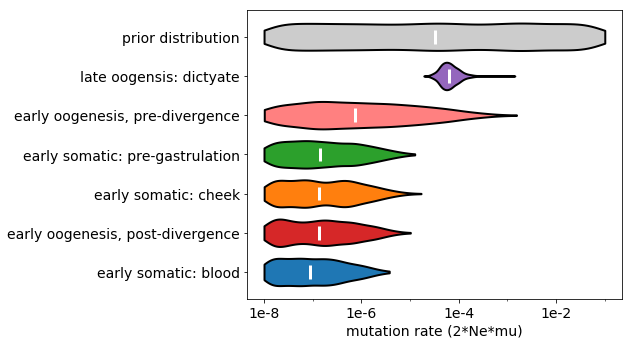

In [10]:
# Plot of posterior distributions of mutation rate parameters


vms = []
vm_colors = []
vm_fz = []
vm_labels = []
for i in range(len(mut_columns)):
    mc = mut_columns[i]
    lc = length_columns[i]
    name = lc.replace('_l', '')
    if name in ['bl', 'ch']:
        continue
    color = colordat.loc[colordat['tissue'] == lc.replace('_l', ''), 'color']
    datp = dat[mc]
    with np.errstate(divide='ignore'):
        datp_l = np.log10(dat[lc])
    finitefilt = np.isfinite(datp_l)
    p0 = (~finitefilt).sum()/float(dat.shape[0])
    vm_labels.append(better_labels[name])
    vm_colors.append(color)
    vm_fz.append((~finitefilt).sum()/float(finitefilt.shape[0]))
    vms.append(np.log10(datp.values[finitefilt]))


mpl.rcParams.update({'font.size':14})
# this requires the previous cell be run in order to set up the violin plot data
uniform_sample = npr.uniform(-8, -1, size = 10000)
lw = 2
f, ax = plt.subplots(figsize = (9,5))
n = 1000
vms_thinned = [np.random.choice(d, size = n, replace = False) for d in vms]
vm_order = np.argsort([np.median(vdt) for vdt in vms_thinned])
vd = [vms_thinned[el] for el in vm_order] + [uniform_sample]
vc = [violin_colors[el] for el in vm_order] + ['#cccccc']
vl = [vm_labels[el] for el in vm_order] + ['prior distribution']
parts = plt.violinplot(vd, showmedians = True, widths=0.7, vert = False, showextrema = False, bw_method =  'scott')
for pc, color in zip(parts['bodies'], vc):
    pc.set_facecolor(color)
    pc.set_alpha(1)
    pc.set_edgecolor('black')
    pc.set_linewidth(lw)
parts['cmedians'].set_color('white')
parts['cmedians'].set_linewidth(lw+1)
xticks = np.arange(-8,0)
xticks_major = xticks[::2]
xticks_minor = xticks[1:][::2]
ax.set_xticks(xticks_major)
ax.set_xticks(xticks_minor, minor = True)
xtl = ['1e{}'.format(el) for el in xticks_major]
ax.set_xticklabels(xtl)
ax.set_yticklabels([''] + vl)
ax.set_xlabel('mutation rate (2*Ne*mu)')
f.tight_layout()
#plt.savefig('mutation_rate_violin_final_nc.png', dpi = 500)
#plt.savefig('mutation_rate_violin_final_nc.pdf', dpi = 500)

# Posterior distribution summary statistics

These differ slightly from the paper because of the downsampled chains used for this repository.

In [11]:
# Effective bottleneck size for just early oogenesis
eoo_bots = 2.0/(dat['eoo_pre_l']+dat['eoo_post_l'])
print eoo_bots.median(), hpd(eoo_bots, 0.95)

13.3870649615 [10.27660788 17.34844705]


In [12]:
# Effective rate of bottleneck decrease, linearized between ages 34 and 25
bots_25 = get_bots(25)
bots_34 = get_bots(34)
rates = (bots_34-bots_25)/(34-25)
print np.median(rates), hpd(rates, 0.95)

-0.053310109289840334 [-0.10621387 -0.01057898]


In [13]:
# Mutation rate posterior medians and 95% HPD CIs
for col in dat.columns[dat.columns.str.endswith('_m')]:
    lcol = col.replace('_m', '_l')
    posfilt = dat[lcol] > 0
    if posfilt.sum() > 0:
        print col, dat.loc[finitefilt,col].median(), np.array(hpd(dat.loc[posfilt,col],0.95))
    else:
        print col, None

bl_m None
ch_m None
eoo_post_m 1.22338541113e-07 [1.00002654e-08 2.19484585e-06]
eoo_pre_m 8.82596964414e-07 [1.00021830e-08 9.86814956e-05]
fblo_m 8.9119472838e-08 [1.00001144e-08 1.18734669e-06]
fbuc_m 1.40945225911e-07 [1.00047428e-08 2.87512664e-06]
loo_m 6.11431051941e-05 [2.45450791e-05 1.51470341e-04]
som_m 1.50437315127e-07 [1.00002389e-08 3.17556447e-06]


In [14]:
filt = dat['fblo_l'] > 0
bots_blo = 2.0/dat['fblo_l'][filt]
filt = dat['fbuc_l'] > 0
bots_buc = 2.0/dat['fbuc_l'][filt]

In [15]:
# Somatic bottleneck sizes
print bots_blo.median(), hpd(bots_blo, 0.95)
print bots_buc.median(), hpd(bots_buc, 0.95)

134.889893794 [106.68450509 167.96111102]
262.923990596 [181.35327785 380.46948699]


In [16]:
# Combined effective germline bottleneck size
total_germline = dat['eoo_pre_l']+dat['eoo_post_l']+29.2*dat['loo_l']+dat['som_l']
bots_total = 2.0/total_germline
np.median(bots_total), hpd(bots_total, 0.95)

(10.326658320545095, array([ 8.50629739, 12.31088354]))

In [17]:
# Fraction of combined effective germline bottleneck
# that happens before oogonia diverge
frac_ebs_is_pre = (dat['eoo_pre_l'])/(total_germline)
frac_ebs_is_pre.median(), hpd(frac_ebs_is_pre, 0.95)

(0.006478635462159977, array([0.        , 0.04895484]))

In [18]:
# Fraction of early oogenesis drift that happens before
# vs after oogonia diverge
total_eoo = dat['eoo_pre_l'] + dat['eoo_post_l']
filt = total_eoo > 0
frac_eoo_is_pre = ((dat['eoo_pre_l'])/total_eoo)[filt]
frac_eoo_is_post = 1.0 - frac_eoo_is_pre
frac_eoo_is_post.median(), hpd(frac_eoo_is_post, 0.95)

(0.9915627263104978, array([0.93497898, 1.        ]))

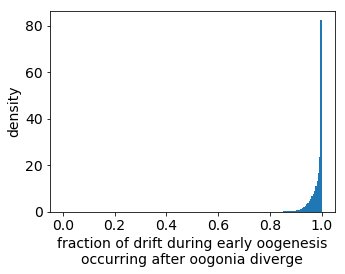

In [19]:
# Plot posterior distribution of fraction of early oogenesis
# drift happening after oogonia diverge
with mpl.rc_context({'font.size': 14}):
    f, ax = plt.subplots(1,1, figsize=(5,4))
    plt.hist(frac_eoo_is_post, np.linspace(0,1,200), normed=True)
    ax = plt.gca()
    ax.set_xlabel('fraction of drift during early oogenesis\noccurring after oogonia diverge')
    ax.set_ylabel('density');
    f = plt.gcf()
    f.tight_layout()